# Main playground for exploration of NN SI model

**Author: Zheng Liu**

## Introduction

We are interested in how neural network can help to predict real spatial interaction data.
This notebook aims to provide step-by-step experiments to compare parametric statistic models (OLS/GLM) and non-parametric statistic models (Neural Networks).

In the first part, we prepare data from simulationin order to validate and examine model and real world SI data which will be used at the end in different models especially NN SI models to evaluate performances.

Next part will compare results using OLS/GLM/NN with the dataset you pick. Before getting NN results, implementation of my simple neural network is explicitly given.

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf # high-level stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
%matplotlib inline

## Data preparation

Following datasets can be loaded by calling functions below:

1. Linear simulation: to test my simple neural net can work perfectly
2. Linear simulation with multivariates: to test my simple neural net can work perfectly
3. Multiplicative simulation: to simulate SI model data with known parameters
4. Real world Austria migration: A toy dataset with 72 entries used in Taylor (2016) and Fischer (2001)
5. Real world NYC taxi snippet: Larger dataset with tract-level interactions (1000 entries)

### 1. Linear simulation

In [9]:
#make toy dataset with error
def loadDatasetLinear(row=1000,error = 0.1):
    b0 = 1
    b1 = 2
    X = np.random.rand(row,1)
    Xe = error*np.random.rand(row,1)
    Y = b0 +b1*X + Xe
    return (X,Y)

### 2.Linear simulation with multivariates:

In [10]:

def loadDatasetVarLn(row=1000,error = 0.1):
    b0 = 1
    b1 = np.array([[1],[1],[1]])
    X = np.random.rand(row,3)
    Xe = error*np.random.rand(row,1)
    Y = b0 +np.dot(X,b1) + Xe
    return (X,Y)

### 3. Multiplicative simulation

In [57]:
#make non-linear dataset
def loadDatasetNonlnMp(row=1000,error=0.001):
    b0 = 1

    Oi = np.random.rand(row,1)
    Dj = np.random.rand(row,1)
    dij = np.random.rand(row,1)+1.0001
    X = np.hstack((Oi,Dj,dij))
    Xe = error*np.random.rand(row,1)
    Y = b0*Oi*Dj/dij + Xe
    return (X,Y)

In [63]:
#make non-linear dataset
def loadDatasetLogMp(row=1000,error=0.001):
    b0 = 1
    b1 = 1
    b2 = 1
    b3 = -1
    Oi = np.random.rand(row,1)
    Dj = np.random.rand(row,1)
    dij = np.random.rand(row,1)+1.0001
    X = np.hstack((Oi,Dj,dij))

    Xe = error*np.random.rand(row,1)
    Y = np.exp(b0+ b1*np.log(Oi) + b2*np.log(Dj) + b3*np.log(dij) + Xe)
    return (X,Y)

### 4. Real world Austria migration

In [28]:
def loadDatasetAustria():
    X = np.load('data/austria_in.npy')
    Y = np.load('data/austria_out.npy')
    return (X,Y)

### 5. Real world NYC taxi snippet

In [30]:
def loadDatasetTaxiSnippet():
    X = np.load('data/simple_taxi_X.npy')
    Y = np.load('data/simple_taxi_Y.npy')
    return (X,Y)

### Load dataset of your choice

In [80]:
dataopt = '1'
if(dataopt == '1'):
    X,Y = loadDatasetLinear()
elif(dataopt == '2'):
    X,Y = loadDatasetVarLn()
elif(dataopt == '3.1'):
    X,Y = loadDatasetNonlnMp()
elif(dataopt == '3.2'):
    X,Y = loadDatasetLogMp()
elif(dataopt == '4'):
    X,Y = loadDatasetAustria()
elif(dataopt == '5'):
    X,Y = loadDatasetTaxiSnippet()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


## Compare results
Following functions of OLSregression/GLMregression/NNregression will give a **scatterplot, MSE, pearson's R**, of known test data y values vs predicted y values using known X values

### Ordinary Least Square
using package **statsmodels**

In [81]:
def OLSregression(X_train,y_train,X_test,y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    model = sm.OLS(y_train,X_train)
    results = model.fit()
    print(results.summary())
    y_pred = results.predict(X_test)
    pear = scipy.stats.pearsonr(y_test[:,0], y_pred)
    print('Pearson\'s r is {:6f}'.format(pear[0]))
    mse = np.mean((y_test[:,0] - y_pred)**2)
    print('MSE is {:6f}'.format(mse))

    df = pd.DataFrame({'X_Axis': X_test[:, 1], 'y_test': y_test[:,0], 'y_pred':y_pred})
    df_m = df.melt('X_Axis', var_name='cols',  value_name='vals')
    plt.figure(figsize=(16, 10))
    sns.scatterplot(x="X_Axis", y="vals", hue='cols', data=df_m)
    return df
    

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.236e+05
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:23:51   Log-Likelihood:                 1705.2
No. Observations:                 800   AIC:                            -3406.
Df Residuals:                     798   BIC:                            -3397.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0501      0.002    512.192      0.0

,X_Axis,y_test,y_pred
0,0.634887,2.276838,2.321268
1,0.244176,1.577487,1.538985
2,0.955596,2.948193,2.963395
3,0.660024,2.381577,2.371598
4,0.689215,2.425888,2.430045
...,...,...,...
195,0.809169,2.703939,2.670217
196,0.607959,2.293289,2.267354
197,0.533066,2.143312,2.117403
198,0.178726,1.383694,1.407939


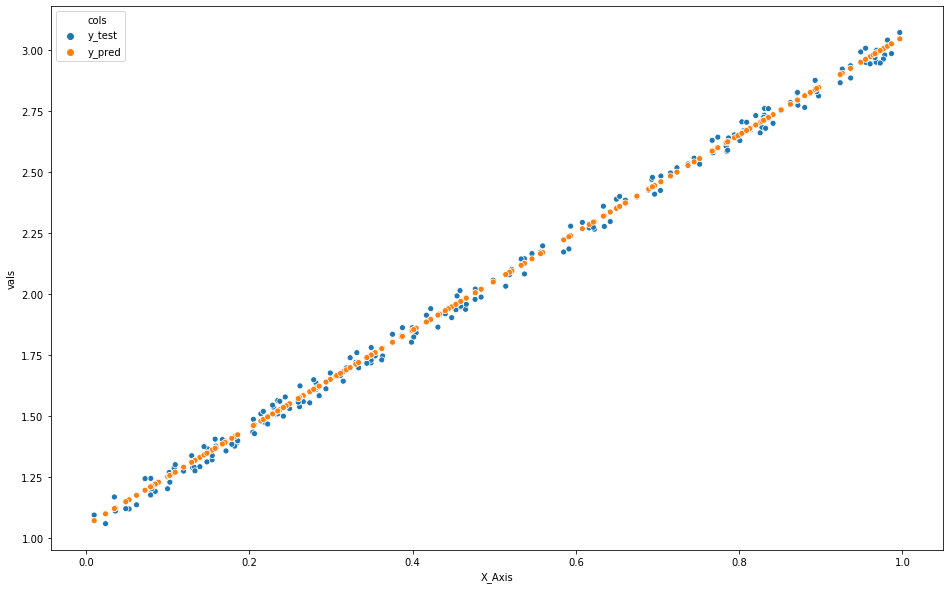

In [82]:
OLSregression(X_train,y_train,X_test,y_test)

### Generalized Linear Models
using package **statsmodels**, current support family of *Poisson*.

In [83]:
def GLMregression(X_train,y_train,X_test,y_test,family='Poisson'):
    if family == 'Poisson':
        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test)
        model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
        results = model.fit()
        print(results.summary())

        y_pred = results.predict(X_test,transform=False)
        pear = scipy.stats.pearsonr(y_test[:,0], y_pred)
        print('Pearson\'s r is {:6f}'.format(pear[0]))
        
        mse = np.mean((y_test[:,0] - y_pred)**2)
        print('MSE is {:6f}'.format(mse))
        
        
        df = pd.DataFrame({'X_Axis': X_test[:, 1], 'y_test': y_test[:,0], 'y_pred':y_pred})

        df_m = df.melt('X_Axis', var_name='cols',  value_name='vals')
        plt.figure(figsize=(16, 10))
        sns.scatterplot(x="X_Axis", y="vals", hue='cols', data=df_m)
        return df
    else:
        return -1

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  800
Model:                            GLM   Df Residuals:                      798
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1043.9
Date:                Wed, 04 Dec 2019   Deviance:                       2.5963
Time:                        20:25:56   Pearson chi2:                     2.57
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1838      0.057      3.229      0.0

,X_Axis,y_test,y_pred
0,0.634887,2.276838,2.250846
1,0.244176,1.577487,1.529827
2,0.955596,2.948193,3.090315
3,0.660024,2.381577,2.307465
4,0.689215,2.425888,2.375007
...,...,...,...
195,0.809169,2.703939,2.673943
196,0.607959,2.293289,2.191733
197,0.533066,2.143312,2.035362
198,0.178726,1.383694,1.434000


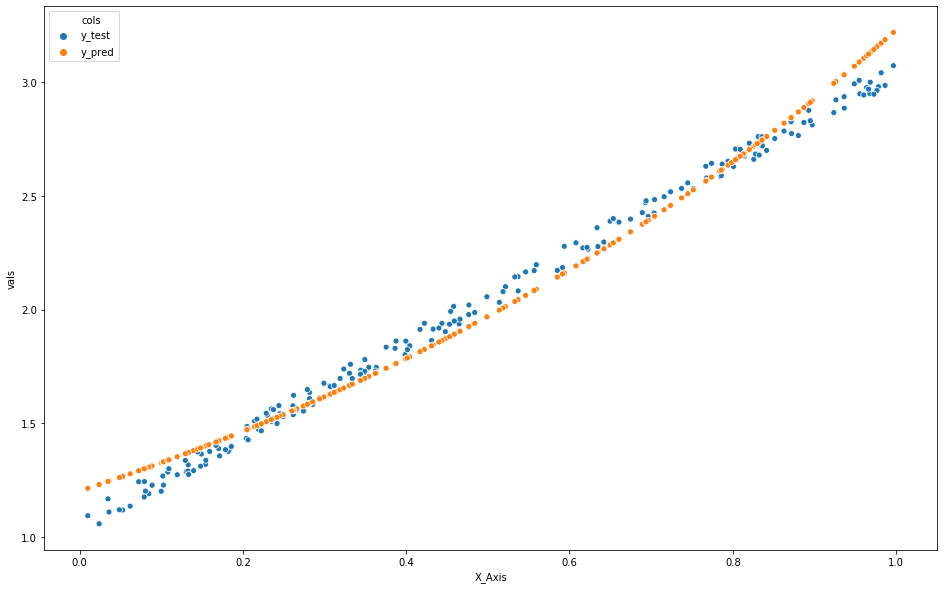

In [84]:
GLMregression(X_train,y_train,X_test,y_test)

### simple Neural Network models
Multi-layer preceptron (MLP) with one hidden layer. Below shows available activation functions including **sigmoid, tanh, ReLU, affine**. 

In [85]:
#activation functions and their gradient functions
def sigmoid(X):
    return 1/(1+np.exp(-X))

def sigmoid_grad(X):
    return sigmoid(X) * (1 - sigmoid(X))

def tanh(z):
    return np.tanh(z)

def tanh_grad(z):
     return 1 - np.tanh(z) ** 2

def ReLU(z):
    return np.clip(z, 0, np.inf)

def ReLU_grad(z):
    return (z > 0).astype(int)

def affine(X,slope=1,intercept=0):
     return slope * X + intercept
    
def affine_grad(X,slope=1,intercept=0):
    return slope * np.ones_like(X)

#### define neural network model

Construct neural network by using numpy only so that user is able to monitor the changing of weights during training. 

In [86]:

class NeuralNetwork:
    def __init__(self, input_dim, output_dim=1,hidden_dim = 4,lr=0.005,
                 act1 = sigmoid,
                 act2 = affine,
                 grad1 = sigmoid_grad,
                 grad2 = affine_grad):
        #init weights
        self.weights1   = np.random.rand(input_dim+1,hidden_dim) 
        self.weights2   = np.random.rand(hidden_dim,output_dim)                 
        #set learning rate
        self.lr         = lr
        self.activation1 = act1
        self.activation2 = act2
        self.grad1 = grad1
        self.grad2 = grad2
      
    def print_w(self):
        '''print weight to inspect the current values of network'''  
        print('print_weights ------------>')
        print(self.weights1)
        print(self.weights2)
        
    def feedforward(self,X):
        X = np.hstack((X,np.ones((X.shape[0],1))))
        self.layer1 = self.activation1(np.dot(X, self.weights1))
        self.output = self.activation2(np.dot(self.layer1, self.weights2))
        return self.output
    def backprop(self,X, Y):
        X = np.hstack((X,np.ones((X.shape[0],1))))
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights2 = np.dot(self.layer1.T, (2*(Y - self.output) * affine_grad(np.dot(self.layer1, self.weights2))))
        d_weights1 = np.dot(X.T,  \
                            (np.dot(2*(Y - self.output) * self.grad2(np.dot(self.layer1, self.weights2)), self.weights2.T)\
                             * self.grad1(np.dot(X, self.weights1))))

        # update the weights with the derivative (slope) of the loss function multiply learning rate
        self.weights1 += d_weights1*self.lr
        self.weights2 += d_weights2*self.lr
    
    def test(self,X):
        '''get predicted values for any input data'''
        X = np.hstack((X,np.ones((X.shape[0],1))))
        hidden_layer1 = self.activation1(np.dot(X, self.weights1))
        return self.activation2(np.dot(hidden_layer1, self.weights2))
        
    def train(self,X,Y,epoch):
        '''train model with X and Y for num_train_iterations times'''
        #print('training  ---------------->')
        for iteration in range(epoch): 
            self.feedforward(X) 
            self.backprop(X,Y)
            #print interim MSE
#             if iteration % 100 == 0:
#                 mse = np.mean((self.output - Y)**2)
#                 print("Epoch ", iteration, "MSE: ", mse)
                

#### Training and testing NN model

Extra options can be **Batch size, epoch**

In [87]:
def NNregression(X_train, X_test, y_train, y_test,
                 batch_size = 4,
                 epoch = 500
                ):

    #initialize network with fixed output dim of 1
    neural_network = NeuralNetwork(X_train.shape[1],1,lr=1e-3)

    for index in range(0,X_train.shape[0],batch_size):

        #get batch X and Y
        batch_X=X_train[index:min(index+batch_size,X_train.shape[0]),:]
        batch_Y=y_train[index:min(index+batch_size,y_train.shape[0])]

        #train model with batch
        neural_network.train(batch_X,batch_Y,epoch)
    y_pred = neural_network.feedforward(X_test)[:,0]
    pear = scipy.stats.pearsonr(y_test[:,0], y_pred)

    print('Pearson\'s r is {:6f}'.format(pear[0]))

    mse = np.mean((y_test[:,0] - y_pred)**2)
    print('MSE is {:6f}'.format(mse))


    df = pd.DataFrame({'X_Axis': X_test[:, 0], 'y_test': y_test[:,0], 'y_pred':y_pred})
    print(df)
    df_m = df.melt('X_Axis', var_name='cols',  value_name='vals')
    plt.figure(figsize=(16, 10))
    sns.scatterplot(x="X_Axis", y="vals", hue='cols', data=df_m)


Pearson's r is 0.998585
MSE is 0.001350
       X_Axis    y_test    y_pred
0    0.634887  2.276838  2.313011
1    0.244176  1.577487  1.502435
2    0.955596  2.948193  2.924543
3    0.660024  2.381577  2.364986
4    0.689215  2.425888  2.424755
..        ...       ...       ...
195  0.809169  2.703939  2.661505
196  0.607959  2.293289  2.256899
197  0.533066  2.143312  2.099244
198  0.178726  1.383694  1.377082
199  0.966277  2.968957  2.942407

[200 rows x 3 columns]


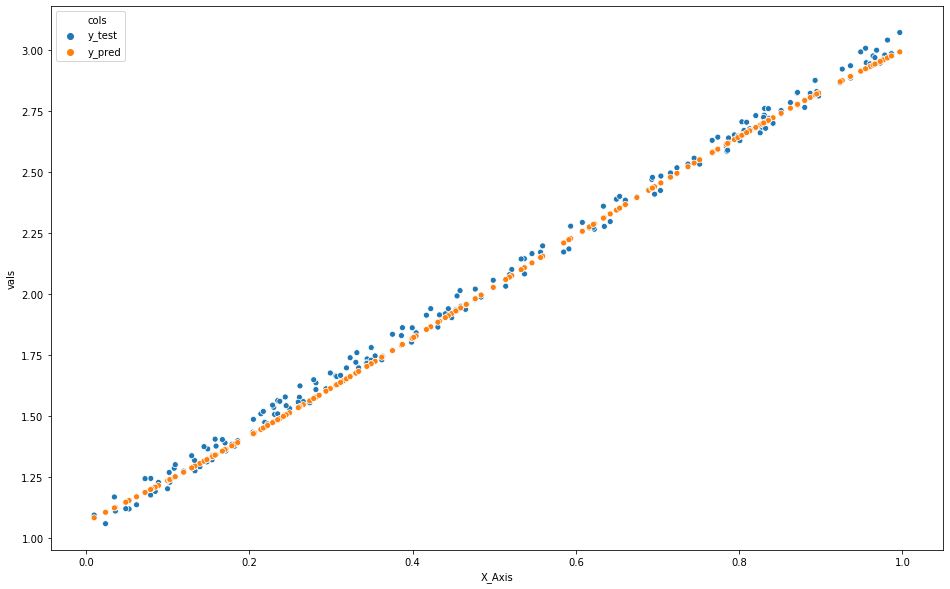

In [88]:
NNregression(X_train, X_test, y_train, y_test)

In [35]:
#legacy code
#prototyping code

# batch_size = 4

# #initialize network with fixed output dim of 1
# neural_network = NeuralNetwork(X_train.shape[1],1,lr=1e-3)

# for index in range(0,X_train.shape[0],batch_size):
    
    
#     #get batch X and Y
#     batch_X=X_train[index:min(index+batch_size,X_train.shape[0]),:]
#     batch_Y=y_train[index:min(index+batch_size,y_train.shape[0])]
    
#     #train model with batch
#     neural_network.train(batch_X,batch_Y,500)
    
#     #print final state of weights
#     neural_network.print_w()

#     # Test the neural network with new test data. 
#     #get predicted y
#     y_pred = neural_network.test(X_test)
#     #compare predicted y and groundtruth 
# #     print('predicted data ----------->')
# #     print(y_pred)
# #     print('real data ---------------->')
# #     print(y_test)
#     #calculate MSE
#     mse = np.mean((y_test - y_pred)**2)
#     print('MSE on test data --------->')
#     print(mse)